# LAB4 : Heartbeat Detection in ECG Signal using Cross-Correlation  
<a target="_blank" href="https://colab.research.google.com/github/zamaS24/DCP_Labs/blob/master/DCP_lab4.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## 1. loading ecg signal 

ecg keys  Index([' Sample Value'], dtype='object')


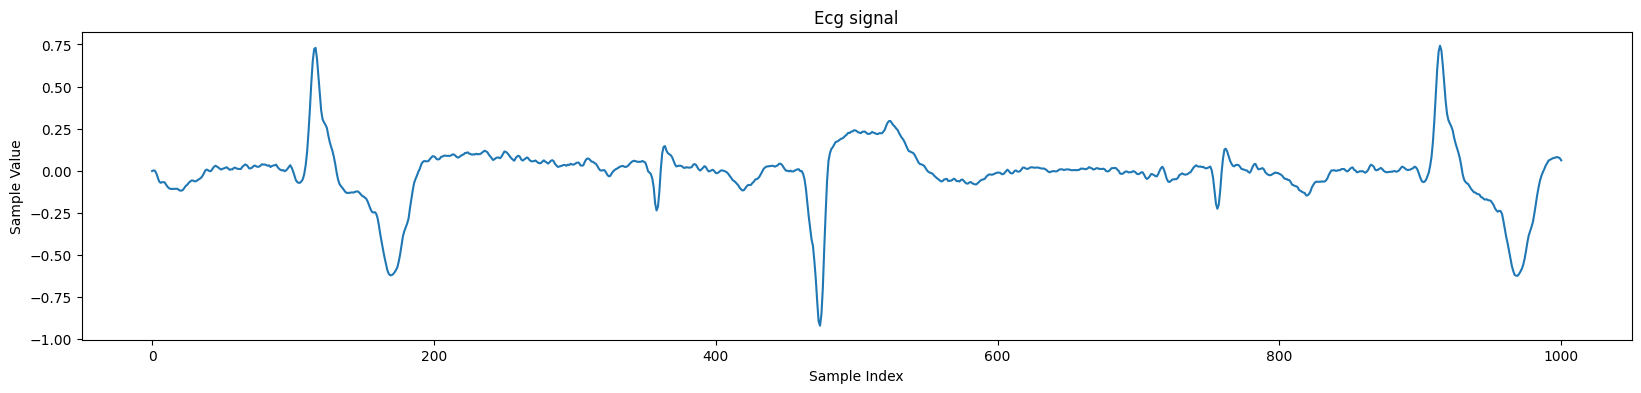

idx min 474


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

# if you are in colab, you need to upload the sample.csv 
ecg_data = pd.read_csv('sample.csv')
print('ecg keys ', ecg_data.columns) # column name : ' Saple Value'

plt.figure(figsize = (20,4), dpi = 100)
plt.plot(ecg_data[' Sample Value']) 
plt.title('Ecg signal')
plt.xlabel('Sample Index')
plt.ylabel('Sample Value')
plt.show()



## 2. extracting heartbeat template

len of template :  200


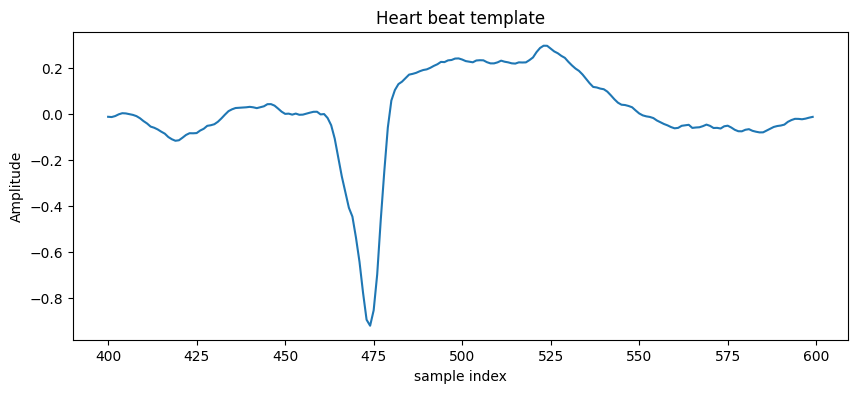

-0.01328741

In [ ]:
template = ecg_data[' Sample Value'][400:600]  
print('len of template : ', len(template))

plt.figure(figsize = (10,4), dpi = 100)
plt.plot(template)
plt.title('Heart beat template')
plt.xlabel('sample index')
plt.ylabel('Amplitude')
plt.show()



> **NOTE**  *About what we should get later*  
> we know that len(template)= 200  
> it means the template matches (completely overlapps) signal in the index 400 + 200 -1 = 599 at the correlated signal
> because the filter goes step by step forward, giving us correlated signal values  and once it overlapps the template, it means he has moved from 0 to the beggining of the filter, and then moved len(filter), and at this point he is completely overlapping the template

## 3. Implementing cross correlation 

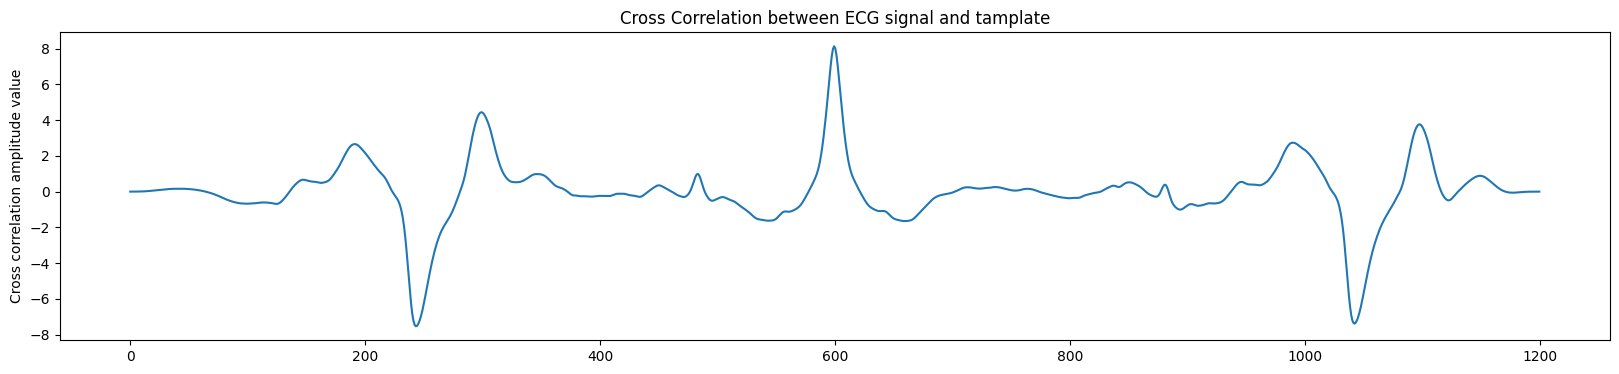

In [ ]:

from scipy.signal import correlate

def calculate_cross_correlation(ecg_signal, template):
    cross_corr = correlate(ecg_signal, template, mode='full')
    
    return cross_corr

cross_corr_signal = calculate_cross_correlation(ecg_data[' Sample Value'], template)

plt.figure(figsize = (20,4), dpi = 100)
plt.plot(cross_corr_signal)
plt.title('Cross Correlation between ECG signal and tamplate')
plt.ylabel('Cross correlation amplitude value')
plt.show()

## 4. Applying thresholdign peaks detection 

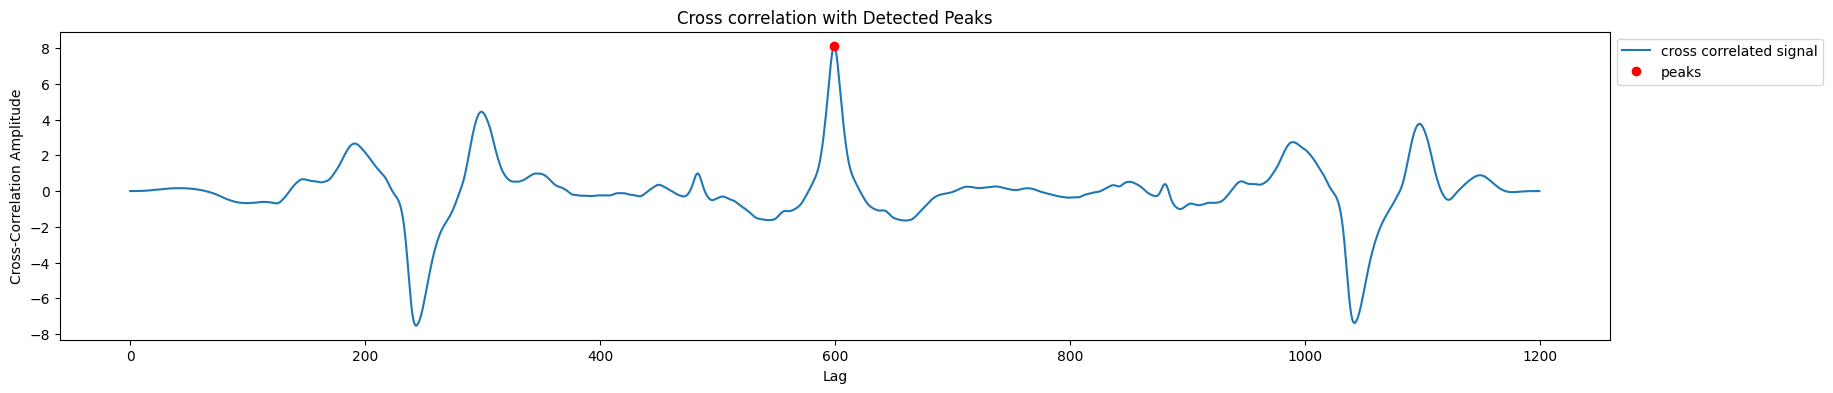

type of peaks :  <class 'numpy.ndarray'>
Detected peaks at indices: [599]
Peak values: [8.13234664]
len of ground truths : 1200
[False False False ... False False False]
[ True]


In [ ]:

# INFO: the find peaks is impleented with differnt methods in the assignement of finding R peaks in ecg signal
# for now we will use provided scipy functions

from scipy.signal import find_peaks


# threshold is obtained by trying differnt threshold testing
threshold = 0.75 * max(cross_corr_signal)  # 0.5 value is not good, but 0.75 is giving the desired peak

# peak detection is simply the  indexes, where signal[index] > peak 
peaks, _ = find_peaks(cross_corr_signal, height=threshold)


plt.figure(figsize=(20,4), dpi=100)
plt.plot(cross_corr_signal, label='cross correlated signal')
plt.plot(peaks, cross_corr_signal[peaks], "o", color='r', label='peaks') 

plt.title('Cross correlation with Detected Peaks')
plt.ylabel('Cross correlation Amplitude')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# for debugging purposes  
print('type of peaks : ', type(peaks))
print("Detected peaks at indices:", peaks)
print("Peak values:", cross_corr_signal[peaks])

# I will prepare ground truths now because I need them later for performance calculation
ground_truths = cross_corr_signal == cross_corr_signal[peaks]
print('len of ground truths :', len(ground_truths))
print(ground_truths)
print(ground_truths[peaks])

## 5. Simulating Noise and Varying the SNR

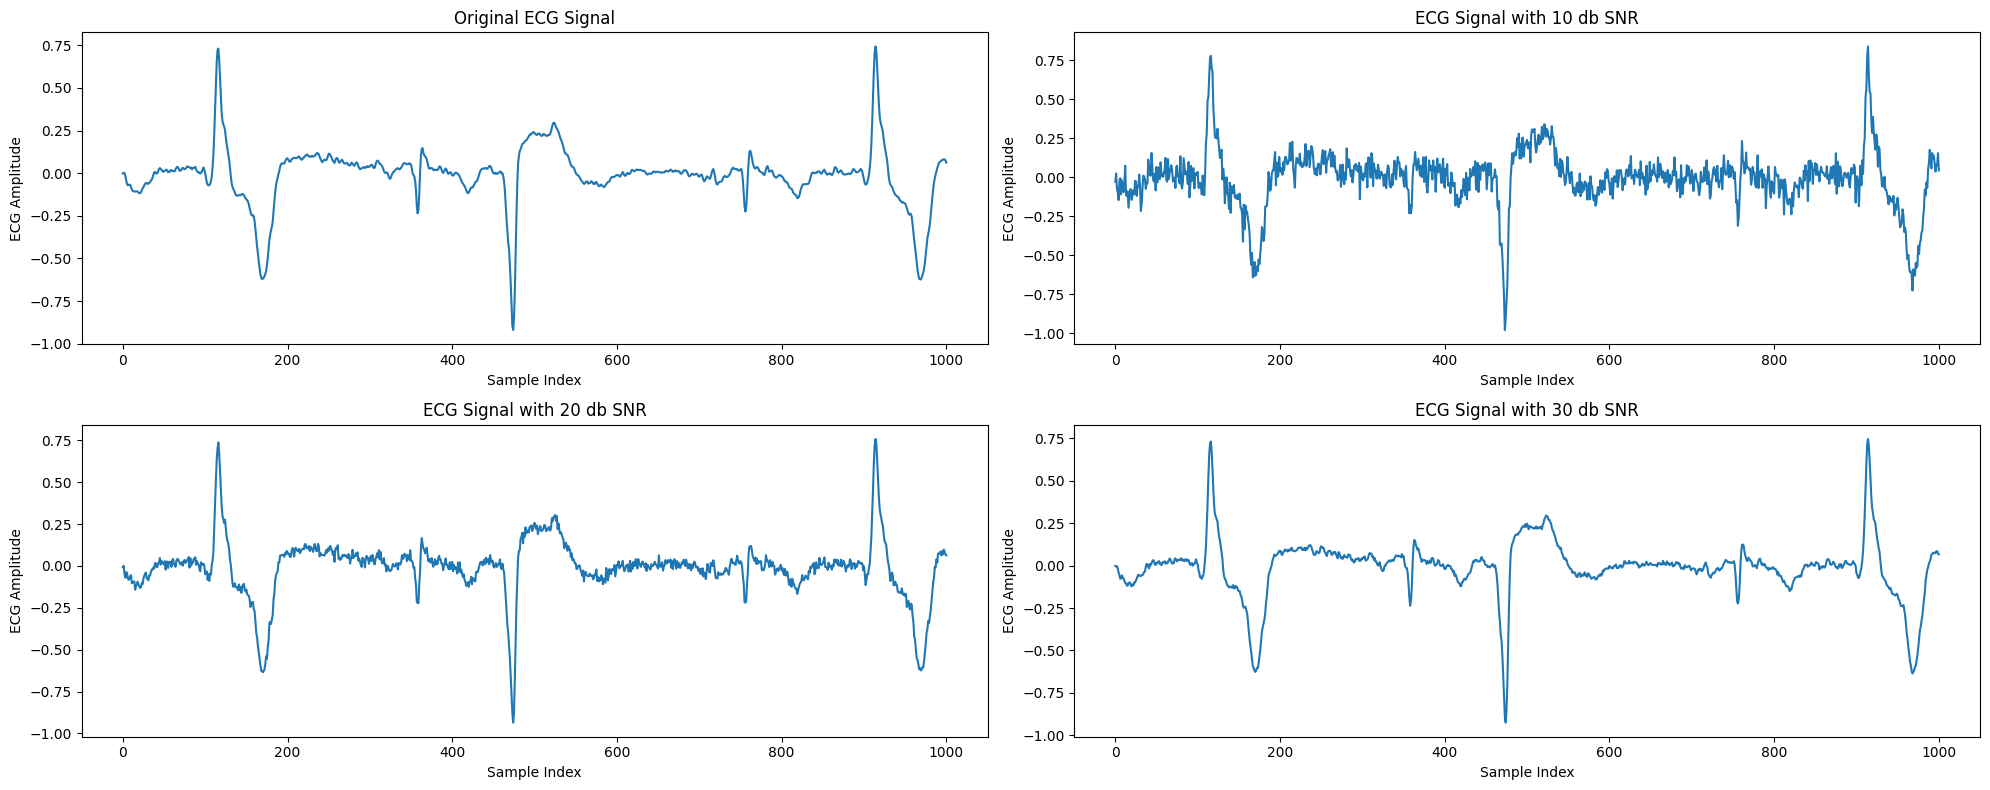

In [66]:

# same as how we add gaussian noise to images but here is 1d
def add_gaussian_noise(signal, snr_db):

    # calculate signal power and convert SNR from dB to linear scale
    signal_power = np.mean(signal ** 2)
    snr_linear = 10 ** (snr_db / 10)
    
    # calculate noise power
    noise_power = signal_power / snr_linear
    
    # generate Gaussian noise
    noise = np.sqrt(noise_power) * np.random.normal(size=signal.shape)
    
    # add noise to the original signal
    noisy_signal = signal + noise
    
    return noisy_signal

# Generate noisy signals with different SNR levels
# Array for the snrs, and array for the noisy signals 
# TODO: Might use dictionnary if needed later, for better readability 
snr_levels = [10, 20, 30]
noisy_signals = [add_gaussian_noise(ecg_data[' Sample Value'], snr) for snr in snr_levels]

# Plot the original and noisy signals
plt.figure(figsize=(20, 8), dpi=100)
plt.subplot(2, 2, 1) #  grid of (2,2) 1 for original and three for noisy signals
plt.plot(ecg_data[' Sample Value'])
plt.title('Original ECG Signal')
plt.xlabel('Sample Index')
plt.ylabel('ECG Amplitude')


for i, snr in enumerate(snr_levels):
    plt.subplot(2, 2, i + 2) #2,3,4
    plt.plot(noisy_signals[i])
    plt.title(f'ECG Signal with {snr} db SNR')
    plt.xlabel('Sample Index')
    plt.ylabel('ECG Amplitude')

plt.tight_layout()
plt.show()

## 7. Detecting Heartbeat in the noisy signals using thresholding

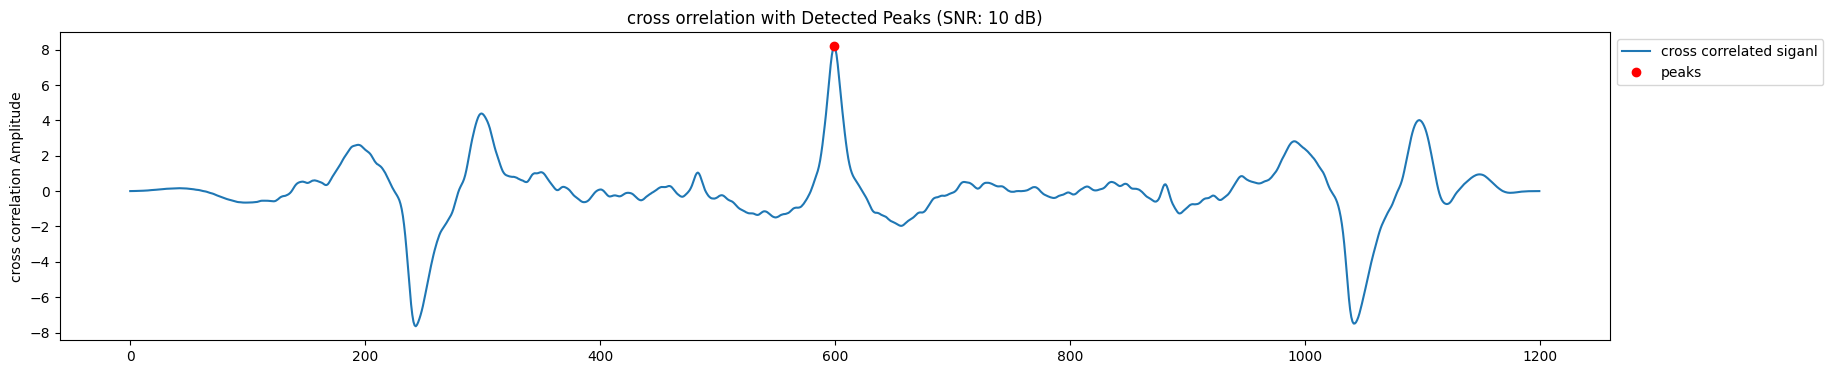

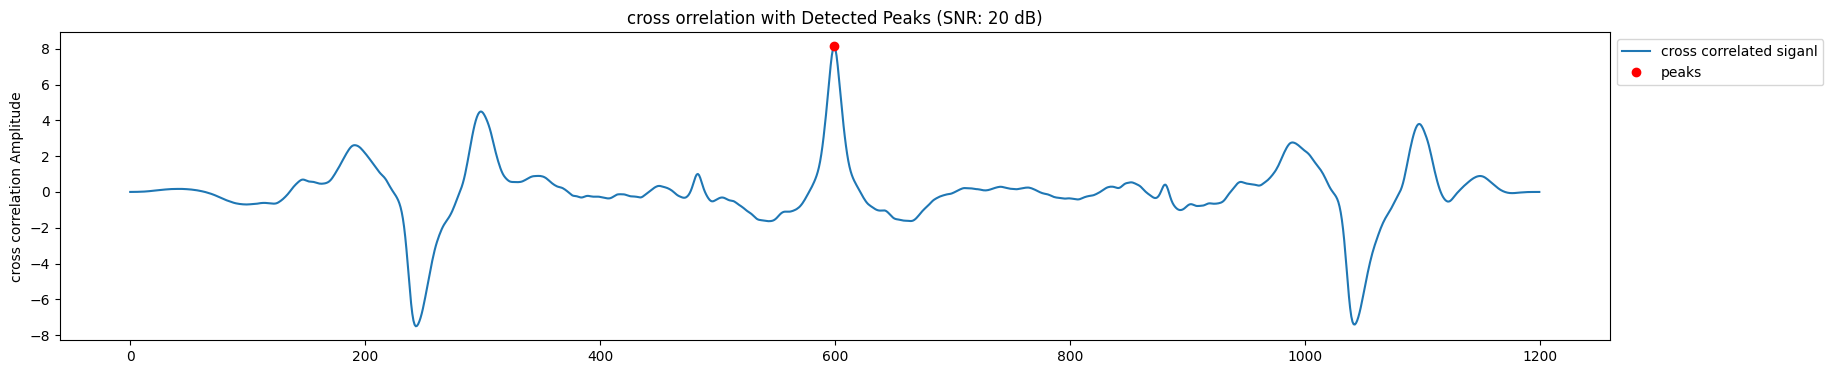

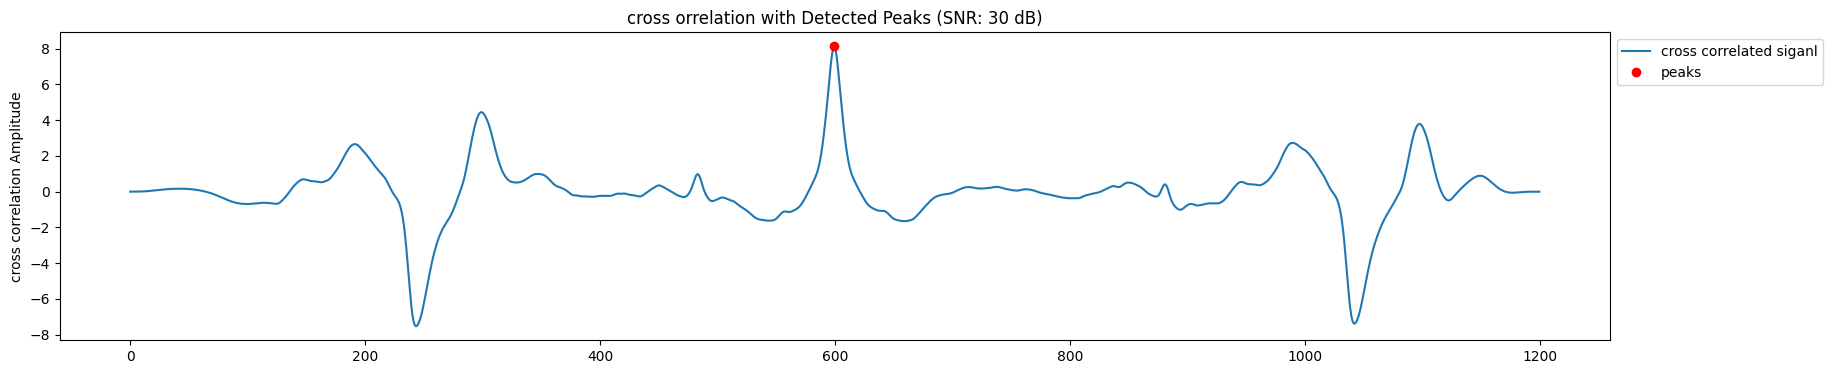

{10: {'peaks': array([599], dtype=int64), 'num_peaks': 1, 'estimations': array([False, False, False, ..., False, False, False])}, 20: {'peaks': array([599], dtype=int64), 'num_peaks': 1, 'estimations': array([False, False, False, ..., False, False, False])}, 30: {'peaks': array([599], dtype=int64), 'num_peaks': 1, 'estimations': array([False, False, False, ..., False, False, False])}}


In [67]:
# Function to detect heartbeats in a noisy signal or any signal, here it's noisy just for our test case
def detect_heartbeats(noisy_signal, template, threshold_factor=0.75)-> (np.ndarray, np.ndarray):

    cross_corr = calculate_cross_correlation(noisy_signal, template)
    threshold = threshold_factor * max(cross_corr)
    peaks, _ = find_peaks(cross_corr, height=threshold)
    
    return peaks, cross_corr

# Saving results in dictionary 
detection_results = {}

# applying the detectionn to each noisy signal
for snr, noisy_signal in zip(snr_levels, noisy_signals):
    peaks, cross_corr = detect_heartbeats(noisy_signal, template)
    
    # Plot the cross correlation result with detected peaks
    plt.figure(figsize=(20, 4), dpi=100)
    plt.plot(cross_corr,label='cross correlated siganl')
    plt.plot(peaks, cross_corr[peaks], "o", color='red', label='peaks')  
    plt.title(f'cross orrelation with Detected Peaks (SNR: {snr} dB)')
    plt.ylabel('cross correlation Amplitude')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    
    # save the detection results in dictionary
    detection_results[snr] = {
        'peaks': peaks,
        'num_peaks': len(peaks),

        # adding estimation array for performance metrics for later 
        # estimation array is a binary array for classification : peak / non peak
        'estimations': cross_corr == cross_corr[peaks]
    }

print(detection_results)

> **NOTE**  
>it seems that we have detected all the peaks, even with the noise. and that's great

## 8. Analyzing detection performance 



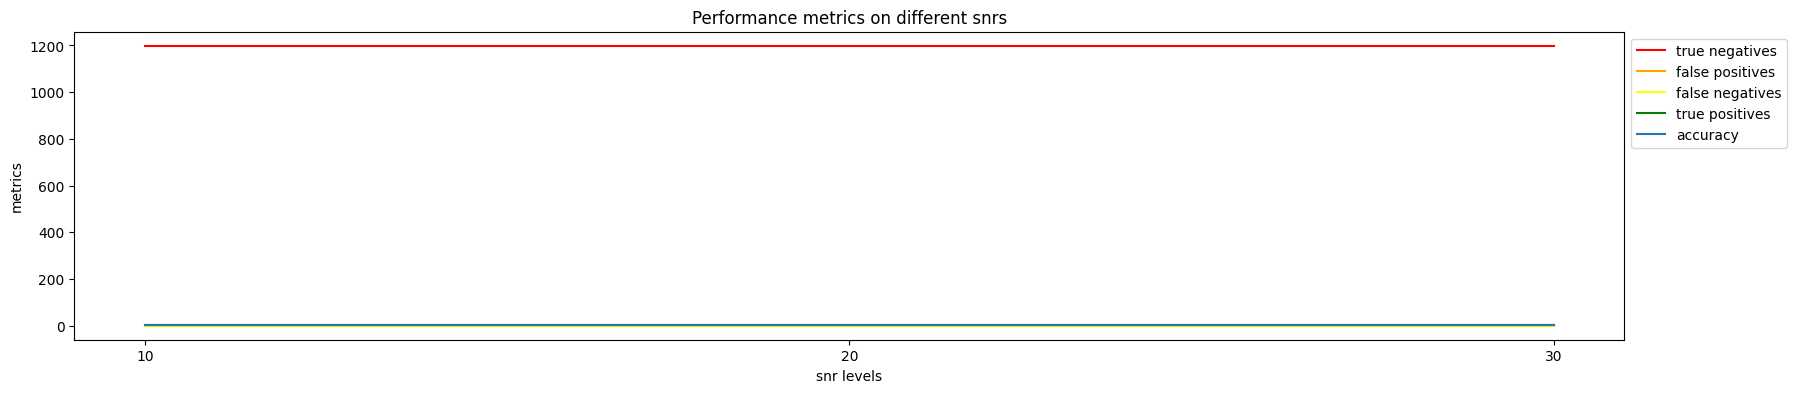

In [ ]:
# it is obvious based on the previous results that for all the three noisy signals we have : 
# TP = 1
# FP = 0
# FN = 0
# TN = len(signal) - 1

# accuracy = TP + TN / TP + TN + FP + FN

# but for coding purposes we will compute them 
from sklearn.metrics import confusion_matrix

metrics = {}
for snr in snr_levels: 
    tn, fp, fn, tp = confusion_matrix(ground_truths, detection_results[10]['estimations']).ravel()
    metrics[snr] = {
        'tn': tn, 
        'fp': fp, 
        'fn': fn, 
        'tp':tp, 
        'accuracy': (tp+tn)/(tp+tn+fp+fn)
    }


# x axis is snr metrics 
# y axis will be ploting different plots 

tn_arr = [metrics[snr]['tn'] for x in snr_levels]
fp_arr = [metrics[snr]['fp'] for x in snr_levels]
fn_arr = [metrics[snr]['fn'] for x in snr_levels]
tp_arr = [metrics[snr]['tp'] for x in snr_levels]

plt.figure(figsize=(20, 4), dpi=100)

plt.plot(snr_levels, tn_arr,color='red', label='true negatives')
plt.plot(snr_levels, fp_arr,color='orange', label='false positives')
plt.plot(snr_levels, fn_arr,color='yellow', label='false negatives')
plt.plot(snr_levels, tp_arr,color='green', label='true positives')

plt.title(f'Performance metrics on different snrs')
plt.xlabel('snr levels')
plt.xticks(snr_levels)
plt.ylabel('metrics')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()



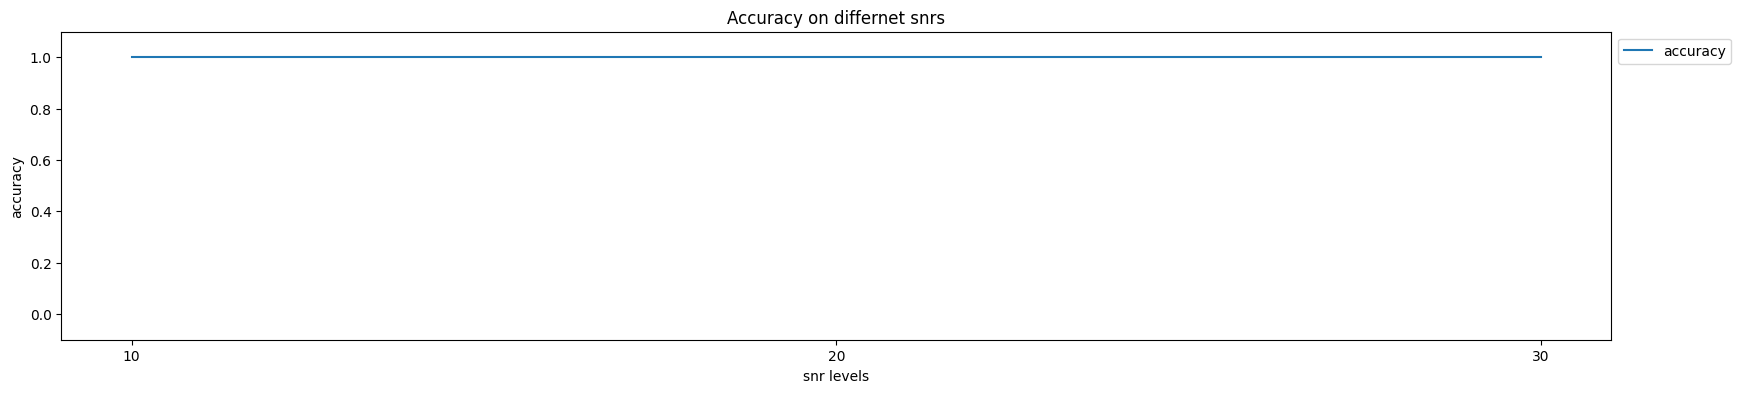

In [72]:
# i need to plot accuracy alone sice the previsou plot y ranges from 0 to 1200 we can't see the accuracy
acc_arr = [metrics[snr]['accuracy'] for x in snr_levels]
plt.figure(figsize=(20, 4), dpi=100)
plt.plot(snr_levels, acc_arr, label='accuracy')

plt.title(f'Accuracy on differnet snrs')
plt.xlabel('snr levels')
plt.xticks(snr_levels)
plt.ylabel('accuracy')
plt.ylim((-0.1,1.1))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()